# Distributed analysis example: exhaustive ddG PSSM

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score

In [3]:
import pandas

In [4]:
import seaborn
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [5]:
import Bio.SeqUtils
import Bio.Data.IUPACData as IUPACData

## Load test structure from pdb, import and pre-pack.

In [ ]:
test_structure = !curl https://files.rcsb.org/download/1UBQ.pdb
test_structure = "\n".join(test_structure)

In [ ]:
input_protocol = """
<ROSETTASCRIPTS>
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack" task_operations="only_pack" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""

In [ ]:
input_relax = rosetta_scripts.SingleoutputRosettaScriptsTask(input_protocol)
# Syntax check via setup
input_relax.setup()

In [ ]:
raw_input_pose = score.ScorePoseTask()(io.pose_from_pdbstring(test_structure))

In [ ]:
input_pose = input_relax(raw_input_pose)

## Perform exhaustive point mutation and pack

In [ ]:
def mutate_residue(input_pose, res_index, new_aa, res_label = None):
    import pyrosetta.rosetta.core.pose as pose
    
    work_pose = packed_pose.to_pose(input_pose)
    
    # Annotate strucure with reslabel, for use in downstream protocol
    # Add parameters as score, for use in downstream analysis
    if res_label:
        work_pose.pdb_info().add_reslabel(res_index, res_label)
        pose.setPoseExtraScore(work_pose, "mutation_index", res_index)
        pose.setPoseExtraScore(work_pose, "mutation_aa", new_aa)
    
    if len(new_aa) == 1:
        new_aa = str.upper(Bio.SeqUtils.seq3(new_aa))
    assert new_aa in map(str.upper, IUPACData.protein_letters_3to1)
    
    protocol = """
<ROSETTASCRIPTS>
    <MOVERS>
        <MutateResidue name="mutate" new_res="%(new_aa)s" target="%(res_index)i" />
    </MOVERS>
    <PROTOCOLS>
        <Add mover_name="mutate"/>
    </PROTOCOLS>
</ROSETTASCRIPTS>
    """ % locals()
    
    return rosetta_scripts.SingleoutputRosettaScriptsTask(protocol)(work_pose)

In [ ]:
def refine_mutation(input_pose):
    refine = """
<ROSETTASCRIPTS>

  <RESIDUE_SELECTORS>
    <ResiduePDBInfoHasLabel name="mutation" property="mutation" />
    <Not name="not_neighbor">
      <Neighborhood selector="mutation" distance="12.0" />
    </Not>
  </RESIDUE_SELECTORS>
  
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
    <OperateOnResidueSubset name="only_repack_neighbors" selector="not_neighbor" >
      <PreventRepackingRLT/>
    </OperateOnResidueSubset>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack_area" task_operations="only_pack,only_repack_neighbors" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack_area"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
    """
    
    return rosetta_scripts.SingleoutputRosettaScriptsTask(refine)(input_pose)

## Execute mutation and pack on process pool

In [ ]:
import itertools
import pyrosetta

In [ ]:
from multiprocessing import Pool

In [ ]:
with pyrosetta.utility.log.LoggingContext(logging.getLogger("rosetta"), level=logging.WARN):
    with Pool() as p:
        work = [
            (input_pose, i, aa, "mutation")
            for i, aa in itertools.product(range(1, len(packed_pose.to_pose(input_pose).residues) + 1), IUPACData.protein_letters)
        ]
        logging.info("mutating")
        mutations = p.starmap(mutate_residue, work)
        logging.info("refining")
        refinments = p.map(refine_mutation, mutations)

## Analysis of delta score

In [ ]:
result_frame = pandas.DataFrame.from_records(packed_pose.to_dict(refinments))
result_frame["delta_total_score"] = result_frame["total_score"] - input_pose.scores["total_score"] 
result_frame["mutation_index"] = list(map(int, result_frame["mutation_index"]))

In [6]:
#result_frame.to_pickle('result_frame.pkl')
result_frame = pandas.read_pickle('result_frame.pkl')

In [7]:
matplotlib.rcParams['figure.figsize'] = [24.0, 8.0]

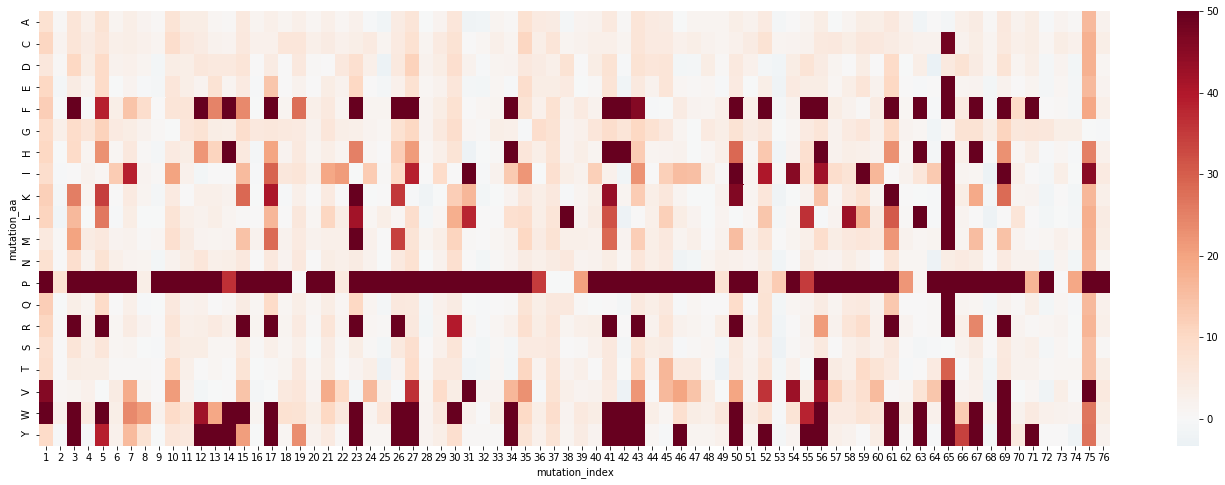

In [8]:
seaborn.heatmap(
    result_frame.pivot("mutation_aa", "mutation_index", "delta_total_score"),
    cmap="RdBu_r", center=0, vmax=50)